In [1]:
import pandas as pd
import tushare as ts
import os
import sys
import time
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from common.config import Config

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [6]:
%%time

stock_df_dict = {}

for symbol in ['EOS']:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
    stock_df = stock_df.loc[:, ['date', 'close']]

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期，和news_df['publish_time']一致
    stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    stock_df.set_index(['date'], inplace=True)
    stock_df = stock_df.sort_index(axis=0, ascending=True)

    stock_df['pct_change'] = stock_df.close.pct_change(1)
    
#     stock_df = stock_df['2016-01-01':]
    
    stock_df_dict[symbol] = stock_df


Wall time: 339 ms


In [7]:
stock_df_dict['EOS']

,close,pct_change
date,,
2017-07-01,1.01,NaN
2017-07-02,2.71,1.683168
2017-07-03,4.09,0.509225
2017-07-04,3.37,-0.176039
2017-07-05,3.00,-0.109792
2017-07-06,3.36,0.120000
2017-07-07,2.80,-0.166667
2017-07-08,2.59,-0.075000
2017-07-09,2.29,-0.115830


In [14]:
%%time
# %xmode

### Turtle

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

# start_date = '2017-07-02'
start_date = '2018-01-01'
end_date = '2018-05-23'

yesterday = None

show_df = None
show_df = stock_df_dict['EOS'].copy()
show_df['CASH_T'] = pd.np.nan
show_df['PROPERTY_T'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['EOS'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue


    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH
    # int(df.loc[:10].tail(1)['b'])
    for order in hold:
#         print(order)
        PROPERTY = PROPERTY + float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2]
#     PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)
        
        N = 10
        try:
            is_sell = (stock_df_dict[order[1]].loc[today, 'close'] == (stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min()).loc[today])
        except:
            print(stock_df_dict[order[1]].loc[:, 'close'].rolling(N).min())
            raise 'FUCK'
#         print(is_sell)
        
        if is_sell:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 退出 SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in ['EOS']:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        try:
            # turtle buy N days
            N = 20
            is_buy = (stock_df_dict[symbol].loc[today, 'close'] == (stock_df_dict[symbol].loc[:, 'close'].rolling(N).max()).loc[today])

            if is_buy:
                if CASH < 10000:
                    continue
                buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
                CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
#                 hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], stock_df_dict[symbol].loc[yesterday, 'close']])
                hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0])
                print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], 0))
                recode_df = recode_df.append(
                    {
                        'date': today,
                        'ops': 'BUY',
                        'reason': 'ENTER',
                        'symbol': symbol,
                        'count': buy,
                        'price': stock_df_dict[symbol].loc[today, 'close'],
                        'buy_price': stock_df_dict[symbol].loc[today, 'close'],
    #                     'expect': stock_df_dict[symbol].loc[yesterday, 'close'],
                        'expect': 0,
                        'profit': 0,
                        'cash': CASH,
                        'property': PROPERTY,
                    },
                    ignore_index=True
                )
        except:
            print(symbol, today, 'FUCK')
            raise 'FUCK'
    
    show_df.loc[today, 'CASH_T'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY_T'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

s_p = stock_df_dict['EOS'].loc[start_date, 'close']
e_p = stock_df_dict['EOS'].loc[end_date, 'close']
print('EOS', s_p, e_p, e_p / s_p)


2018-01-06 进场 BUY  EOS * 794 @ 12.580000 EXPECT 0.000000
2018-01-12 进场 BUY  EOS * 654 @ 13.750000 EXPECT 0.000000
2018-01-13 进场 BUY  EOS * 499 @ 16.230000 EXPECT 0.000000
2018-01-30 退出 SELL EOS * 794 @ 11.560000
2018-01-30 退出 SELL EOS * 499 @ 11.560000
2018-02-01 退出 SELL EOS * 654 @ 10.210000
2018-04-11 进场 BUY  EOS * 1113 @ 8.490000 EXPECT 0.000000
2018-04-12 进场 BUY  EOS * 978 @ 8.700000 EXPECT 0.000000
2018-04-13 进场 BUY  EOS * 876 @ 8.740000 EXPECT 0.000000
2018-04-18 进场 BUY  EOS * 763 @ 9.030000 EXPECT 0.000000
2018-04-19 进场 BUY  EOS * 657 @ 9.440000 EXPECT 0.000000
2018-04-20 进场 BUY  EOS * 487 @ 11.450000 EXPECT 0.000000
2018-04-23 进场 BUY  EOS * 432 @ 11.610000 EXPECT 0.000000
2018-04-24 进场 BUY  EOS * 295 @ 15.310000 EXPECT 0.000000
2018-04-26 进场 BUY  EOS * 262 @ 15.490000 EXPECT 0.000000
2018-04-27 进场 BUY  EOS * 219 @ 16.670000 EXPECT 0.000000
2018-04-28 进场 BUY  EOS * 174 @ 18.870000 EXPECT 0.000000
2018-04-29 进场 BUY  EOS * 138 @ 21.540000 EXPECT 0.000000
2018-05-11 退出 SELL EOS * 1

In [21]:
%%time

### BT

PROPERTY = 100000
CASH = 100000
hold = []
recode_df = pd.DataFrame(columns=['date', 'ops', 'reason', 'symbol', 'count', 'price', 'buy_price', 'expect', 'profit', 'cash', 'property'])

# start_date = '2017-07-02'
start_date = '2018-01-01'
end_date = '2018-05-23'

yesterday = None

# show_df = None
# show_df = stock_df_dict['399300'].copy()
show_df['CASH'] = pd.np.nan
show_df['PROPERTY'] = pd.np.nan

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
#     print(today, 'START')

    if today not in stock_df_dict['EOS'].index:
#         print(today, 'not in index')
        continue

    if yesterday is None:
        yesterday = today
#         print(today, 'continue')
        continue


    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH
    # int(df.loc[:10].tail(1)['b'])
    for order in hold:
#         print(order)
        PROPERTY = PROPERTY + float(stock_df_dict[order[1]].loc[today, 'close']) * order[2]
#     PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[:today, 'close'].tail(1)) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    for order in hold:
        if today not in stock_df_dict[order[1]].index:
            continue
#         print(order)
        
        is_sell_expect_rise = stock_df_dict[order[1]].loc[today, 'close'] > order[4]
        
        if is_sell_expect_rise:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 盈利 SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'WIN',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif stock_df_dict[order[1]].loc[today, 'close'] / order[3] < 0.75:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 止损 SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'LOSS',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )

        elif today - order[0] > 30:
            hold.remove(order)
            CASH += stock_df_dict[order[1]].loc[today, 'close'] * order[2]
            print('%s 超时 SELL %s * %d @ %f' % (today, order[1], order[2], stock_df_dict[order[1]].loc[today, 'close']))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'SELL',
                    'reason': 'TIMEUP',
                    'symbol': order[1],
                    'count': order[2],
                    'price': stock_df_dict[order[1]].loc[today, 'close'],
                    'buy_price': order[3],
                    'expect': order[4],
                    'profit': (stock_df_dict[order[1]].loc[today, 'close'] - order[3]) * order[2],
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    for symbol in ['EOS']:
        if today not in stock_df_dict[symbol].index:
#             print(symbol, today, 'FUCK1')
            continue
        # buy drop wait rise back
        is_buy = (stock_df_dict[symbol].loc[today, 'pct_change'] < -0.1)
           
        if is_buy:
#             if stock_df_dict[symbol].loc[today, 'close'] < stock_df_dict[symbol].shift(7).loc[today, 'close']:
#                 continue
            if CASH < 10000:
                continue
            buy = int(CASH / 10 / stock_df_dict[symbol].loc[today, 'close'])
#             buy = int(PROPERTY / 2 / stock_df_dict[symbol].loc[today, 'close'])
            CASH -= stock_df_dict[symbol].loc[today, 'close'] * buy
            hold.append([today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], float(stock_df_dict[order[1]].shift(1).loc[today, 'close'])])
            print('%s 进场 BUY  %s * %d @ %f EXPECT %f' % (today, symbol, buy, stock_df_dict[symbol].loc[today, 'close'], float(stock_df_dict[order[1]].shift(1).loc[today, 'close'])))
            recode_df = recode_df.append(
                {
                    'date': today,
                    'ops': 'BUY',
                    'reason': 'ENTER',
                    'symbol': symbol,
                    'count': buy,
                    'price': stock_df_dict[symbol].loc[today, 'close'],
                    'buy_price': stock_df_dict[symbol].loc[today, 'close'],
                    'expect': float(stock_df_dict[order[1]].shift(1).loc[today, 'close']),
                    'profit': 0,
                    'cash': CASH,
                    'property': PROPERTY,
                },
                ignore_index=True
            )
    
    show_df.loc[today, 'CASH'] = CASH
    PROPERTY = CASH + sum([float(stock_df_dict[order[1]].loc[today, 'close']) * order[2] for order in hold])
    show_df.loc[today, 'PROPERTY'] = PROPERTY

    yesterday = today
            

print(CASH)
print(hold)
print(PROPERTY)

s_p = stock_df_dict['EOS'].loc[start_date, 'close']
e_p = stock_df_dict['EOS'].loc[end_date, 'close']
print('EOS', s_p, e_p, e_p / s_p)


2018-01-08 进场 BUY  EOS * 1031 @ 9.690000 EXPECT 12.520000
2018-01-12 盈利 SELL EOS * 1031 @ 13.750000
2018-01-14 进场 BUY  EOS * 775 @ 13.440000 EXPECT 16.230000
2018-01-16 进场 BUY  EOS * 912 @ 10.280000 EXPECT 12.940000
2018-01-20 盈利 SELL EOS * 912 @ 15.520000
2018-01-21 进场 BUY  EOS * 733 @ 13.440000 EXPECT 15.520000
2018-01-30 进场 BUY  EOS * 767 @ 11.560000 EXPECT 14.010000
2018-02-01 进场 BUY  EOS * 781 @ 10.210000 EXPECT 12.200000
2018-02-02 止损 SELL EOS * 775 @ 9.790000
2018-02-03 止损 SELL EOS * 733 @ 9.840000
2018-02-04 止损 SELL EOS * 767 @ 8.610000
2018-02-04 进场 BUY  EOS * 1083 @ 8.610000 EXPECT 9.840000
2018-02-05 止损 SELL EOS * 781 @ 7.060000
2018-02-05 进场 BUY  EOS * 1266 @ 7.060000 EXPECT 8.610000
2018-02-09 盈利 SELL EOS * 1266 @ 9.650000
2018-02-14 盈利 SELL EOS * 1083 @ 9.970000
2018-03-07 进场 BUY  EOS * 1590 @ 6.510000 EXPECT 7.250000
2018-03-17 止损 SELL EOS * 1590 @ 4.670000
2018-04-30 进场 BUY  EOS * 572 @ 17.580000 EXPECT 21.540000
2018-05-11 进场 BUY  EOS * 607 @ 14.900000 EXPECT 17.540000

d:\python3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
d:\python3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
d:\python3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org

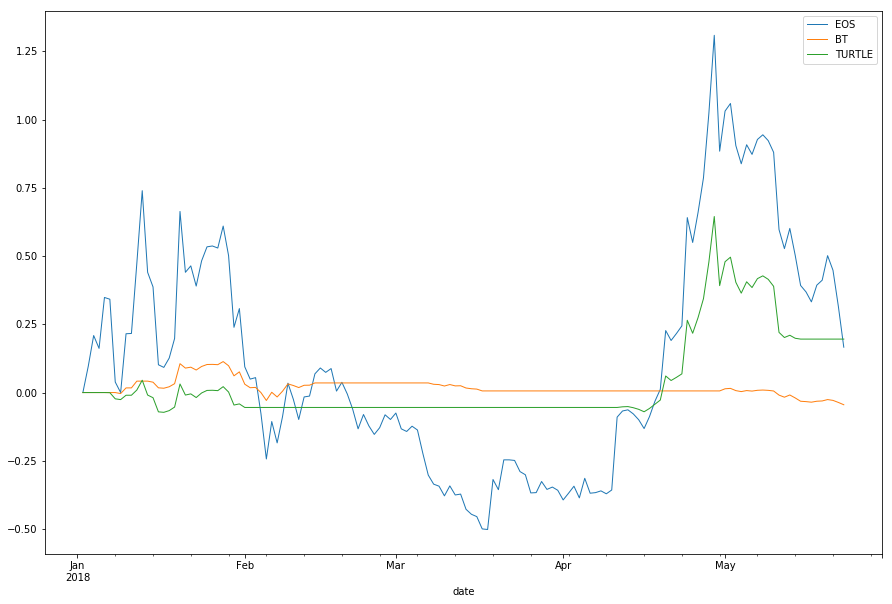

In [22]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False)
df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
df['PROPERTY'] = (df['PROPERTY'] - df.head(1)['PROPERTY'].values) / df.head(1)['PROPERTY'].values
df['PROPERTY_T'] = (df['PROPERTY_T'] - df.head(1)['PROPERTY_T'].values) / df.head(1)['PROPERTY_T'].values
# df['CASH'] = df['CASH'] / df.head(1)['CASH'].values
# stock_df_dict['NDX']

ax = df.plot(kind='line', y='close', label='EOS', linewidth=1)
ax = df.plot(kind='line', y='PROPERTY', secondary_y=False, label='BT', linewidth=1, ax=ax)
ax = df.plot(kind='line', y='PROPERTY_T', label='TURTLE', secondary_y=False, linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()